# iFood CRM Data Analyst Case - Part1

### Description

The objective of the team is to build a predictive model that will produce the highest profit for the
next direct marketing campaign, scheduled for the next month. 
The new campaign, sixth, aims at
selling a new gadget to the Customer Database. 
To build the model, a pilot campaign involving **2.240 customers** was carried out. 
The customers were selected at random and contacted by phone regarding the acquisition of the gadget. 
During the following months, customers who bought the offer were properly labeled. 
The total cost of the sample campaign was 6.720MU and the revenue generated by the customers who accepted the offer was 3.674MU. 
Globally the campaign had a profit of -3.046MU. 
The success rate of the campaign was 15%. 

The objective is of the team is to develop a model that predicts customer behavior and to apply it to the rest of the customer base.
Hopefully the model will allow the company to cherry pick the customers that are most likely to
purchase the offer while leaving out the non-respondents, making the next campaign highly
profitable. Moreover, other than maximizing the profit of the campaign, the CMO is interested in
understanding to study the characteristic features of those customers who are willing to buy the
gadget.

### Key Objectives are:

1. Explore the data – don’t just plot means and counts. Provide insights, define cause and
effect. Provide a better understanding of the characteristic features of respondents;
2. Propose and describe a customer segmentation based on customers behaviors;
3. Create a predictive model which allows the company to maximize the profit of the next
marketing campaign.
4. Whatever else you think is necessary.

### Deliverables:

1. Data Exploration;
2. Segmentation;
3. Classification Model;
4. A short business presentation.

### Data Dictionary and Notes

At the botton of the notebook

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# Load the main dataset
raw_ifood_df = pd.read_csv('ml_project1_data.csv')
raw_ifood_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


## Customer Profile Analysis

These are the columns related to Customer Profile Information 

| categorical 	     | numerical 	            |
|-----------	     |-----------	            |
|Education - ordinal | Income  - continuous  	|
|Marital - nominal   | Kidhome  - discrete 	    |
|                    | Teenhome - discrete 	    |
|      	             | dtCustomer - interval    |
|                    | yearbirth - interval     |



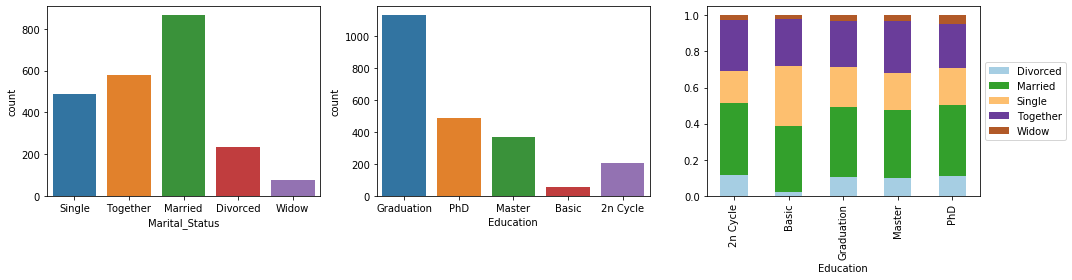

In [8]:
# Taking a look at the categorical variables
fig, ax = plt.subplots(1,3, figsize=(15,4))
sns.countplot(raw_ifood_df['Marital_Status'], ax=ax[0])
sns.countplot(raw_ifood_df['Education'], ax=ax[1])
df_plot = raw_ifood_df.groupby(['Marital_Status', 'Education']).size().reset_index().pivot(columns='Marital_Status', index='Education', values=0)
df_plot.apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax[2],  colormap='Paired')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
fig.show()

In [4]:
df_plot

Marital_Status,Absurd,Alone,Divorced,Married,Single,Together,Widow,YOLO
Education,,,,,,,,
2n Cycle,NaN,NaN,23.0,81.0,37.0,57.0,5.0,NaN
Basic,NaN,NaN,1.0,20.0,18.0,14.0,1.0,NaN
Graduation,1.0,1.0,119.0,433.0,252.0,286.0,35.0,NaN
Master,1.0,1.0,37.0,138.0,75.0,106.0,12.0,NaN
PhD,NaN,1.0,52.0,192.0,98.0,117.0,24.0,2.0



### Some transformations are required:

* yearbirth -> customer_age: in years
* dtCustomer -> customer_days: customer's erollment in days 
* Education -> Education: is ordinal \[Basic: 0, Graduation: 1, 2n Cycle: 2, Master: 3, PhD: 4\]
   - Basic: boolean
   - Graduation: boolean
   - 2n Cycle: boolean
   - Master: boolean
   - PhD: boolean

* Marital -> multiples using Dummy Variables
   - Married: boolean
   - Together: boolean
   - Single, Alone, Absurd, YOLO : boolean
   - Divorced: boolean
   - Widow: boolean 


In [5]:
# Create Customer Age Column
raw_ifood_df['Age'] = date.today().year - raw_ifood_df['Year_Birth']

# Number of days as a customer
raw_ifood_df['Customer_Days'] = (pd.to_datetime("now") - pd.to_datetime(raw_ifood_df['Dt_Customer'])) // np.timedelta64(1,'D')  

# Marital -> multiples using Dummy Variables
raw_ifood_df.loc[raw_ifood_df['Marital_Status'].isin(['Alone','Absurd','YOLO']), 'Marital_Status']  = 'Single'
dummy_mari_var_aux = pd.get_dummies(raw_ifood_df['Marital_Status'], prefix='marital')
ifood_df = pd.concat([raw_ifood_df,dummy_mari_var_aux],axis=1)

# Replace Educational to an ordinal number
dummy_edu_var_aux = pd.get_dummies(raw_ifood_df['Education'], prefix='education')
ifood_df = pd.concat([ifood_df, dummy_edu_var_aux], axis=1)

# Drop unused columns
ifood_df.drop(columns=['ID','Marital_Status','Education','Year_Birth','Dt_Customer'], inplace=True)

# Look of the new dataset
customer_columns = ['Age', 'Customer_Days', 'Income', 'Kidhome', 'Teenhome'] + dummy_mari_var_aux.columns.to_list() + dummy_edu_var_aux.columns.to_list()

customer_ifood_df = ifood_df[customer_columns]
customer_ifood_df.head()

,Age,Customer_Days,Income,Kidhome,Teenhome,marital_Divorced,marital_Married,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD
0,63,2823,58138.0,0,0,0,0,1,0,0,0,0,1,0,0
1,66,2273,46344.0,1,1,0,0,1,0,0,0,0,1,0,0
2,55,2472,71613.0,0,0,0,0,0,1,0,0,0,1,0,0
3,36,2299,26646.0,1,0,0,0,0,1,0,0,0,1,0,0
4,39,2321,58293.0,1,0,0,1,0,0,0,0,0,0,0,1


In [6]:
ifood_df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD'],
      dtype='object')

In [7]:
# Sum of purchases
ifood_df['MntTotal'] = ifood_df.loc[:,['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].sum(axis=1)

# Regular Products
ifood_df['MntRegularProds'] = ifood_df.loc[:,'MntTotal'] - ifood_df.loc[:,'MntGoldProds']

# Campaigns Accepted
ifood_df['AcceptedCmpOverall'] = ifood_df.loc[:,['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

customer_columns_ext = customer_columns + ['MntTotal', 'MntRegularProds', 'MntGoldProds', 'AcceptedCmpOverall']

customer_ifood_df = ifood_df[customer_columns_ext]
customer_ifood_df.head()

,Age,Customer_Days,Income,Kidhome,Teenhome,marital_Divorced,marital_Married,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,MntGoldProds,AcceptedCmpOverall
0,63,2823,58138.0,0,0,0,0,1,0,0,0,0,1,0,0,1529,1441,88,0
1,66,2273,46344.0,1,1,0,0,1,0,0,0,0,1,0,0,21,15,6,0
2,55,2472,71613.0,0,0,0,0,0,1,0,0,0,1,0,0,734,692,42,0
3,36,2299,26646.0,1,0,0,0,0,1,0,0,0,1,0,0,48,43,5,0
4,39,2321,58293.0,1,0,0,1,0,0,0,0,0,0,0,1,407,392,15,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5657070650>,
      dtype=object)

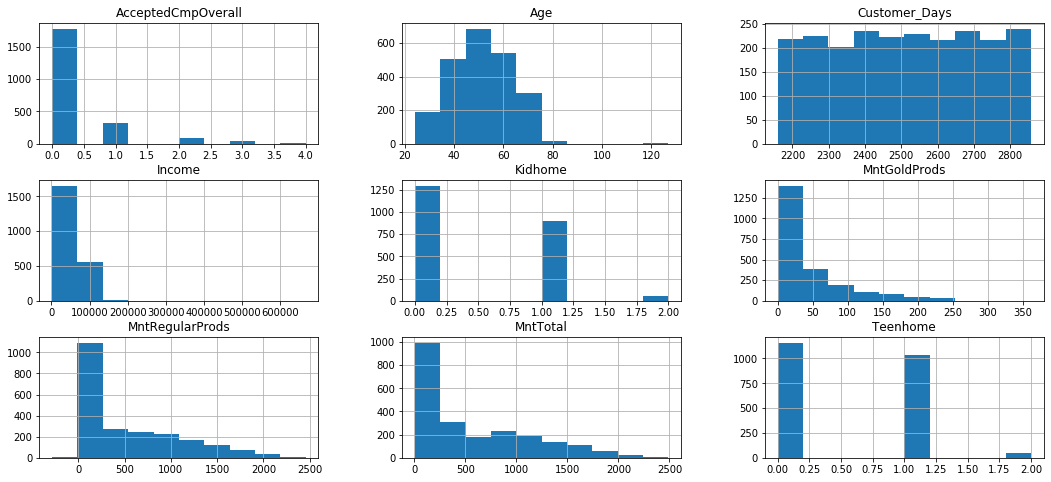

In [9]:
customer_ifood_df.hist( column = ['Age', 'Customer_Days', 'Income', 'Kidhome', 'Teenhome', 'MntTotal', 'MntRegularProds', 'MntGoldProds', 'AcceptedCmpOverall'], figsize=(18,8))

## Outliers and missing data in Income and Age columns

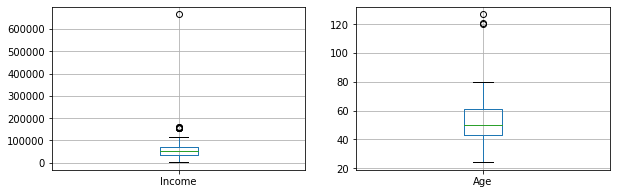

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

customer_ifood_df.boxplot(column=['Income'], ax=ax[0])
customer_ifood_df.boxplot(column=['Age'], ax=ax[1])

In [11]:
len(ifood_df) - len(ifood_df.dropna())

24

In [12]:
ifood_df = ifood_df.dropna()

In [13]:
Q1 = ifood_df.Income.quantile(0.25)
Q3 = ifood_df.Income.quantile(0.75)
IQR = Q3 - Q1

Income_outliers = ifood_df[ifood_df.Income > Q3 + 1.5*IQR]
ifood_df = ifood_df[ifood_df.Income < Q3 + 1.5*IQR]
Income_outliers.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
164,157243.0,0,1,98,20,2,1582,1,2,1,...,0,0,0,0,0,0,1,1607,1606,0
617,162397.0,1,1,31,85,1,16,2,1,2,...,1,0,0,0,0,0,1,105,103,0
655,153924.0,0,0,81,1,1,1,1,1,1,...,0,0,0,0,1,0,0,5,4,0
687,160803.0,0,0,21,55,16,1622,17,3,4,...,0,0,0,0,0,0,1,1713,1709,0
1300,157733.0,1,0,37,39,1,9,2,0,8,...,1,0,0,0,0,1,0,51,43,0


In [14]:
Q1 = ifood_df.Age.quantile(0.25)
Q3 = ifood_df.Age.quantile(0.75)
IQR = Q3 - Q1

Age_outliers = ifood_df[ifood_df.Age > Q3 + 1.5*IQR]
ifood_df = ifood_df[ifood_df.Age < Q3 + 1.5*IQR]
Age_outliers.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
192,36640.0,1,0,99,15,6,8,7,4,25,...,0,0,1,0,0,0,0,40,15,0
239,60182.0,0,1,23,8,0,5,7,0,2,...,0,0,1,0,0,0,0,20,18,0
339,83532.0,0,0,36,755,144,562,104,64,224,...,1,0,0,0,0,0,1,1629,1405,1


## Features Correlation Analysis


In [15]:
corr = ifood_df.drop(['Z_CostContact', 'Z_Revenue'], axis=1).corr(method='spearman')
corr_mask = corr.mask(np.triu(np.ones_like(corr, dtype=np.bool)))
corr_unstacked = corr_mask.unstack().sort_values(ascending = False)

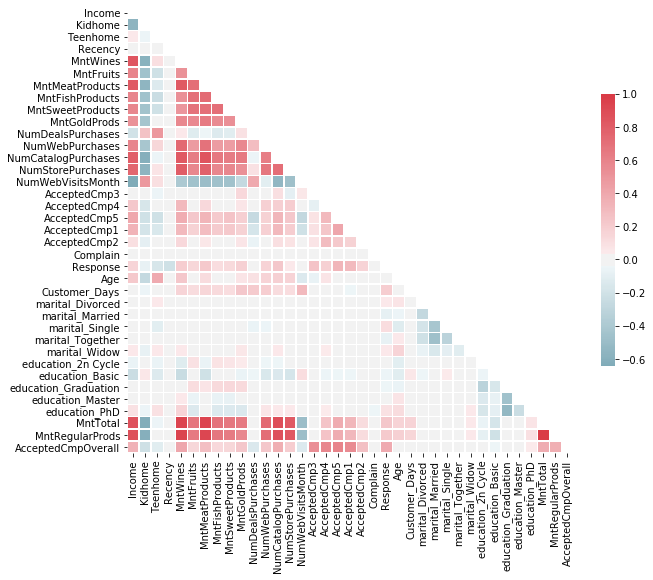

In [16]:
# Draw the heatmap with the mask and correct aspect ratio
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.subplots(figsize=(10,10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [17]:
pd.DataFrame(corr_unstacked[(abs(corr_unstacked)>0.8)&(abs(corr_unstacked)<1)]).sort_index().style.background_gradient(cmap='coolwarm', low=.5, high=-.7)

In [18]:
pd.DataFrame(corr_unstacked[corr_unstacked<-.5]).sort_index().style.background_gradient(cmap='coolwarm', low=-.6, high=.5)

### Correlation Results

Income is a proxy for several other features, such as the amount spend, positively driven by meat and wine and it has a negative correlation with the number of kids home and the visits on the websites.

The amount spend on Wine is, besides being related to high income, to the amount spend on Meat and it's purchased or in Catalog or in Stores.

The number of kids is negative related to income, amont spend in total and, consequently, related to wine.
Higher Income is also related to accept Campaigns.



## Segmentation of Customers

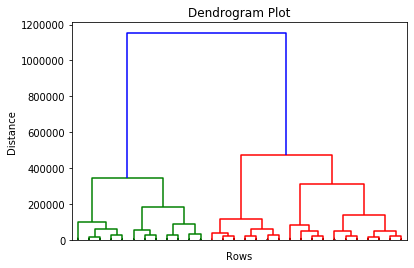

In [31]:

ifood_df_clustering = ifood_df.drop(['Z_CostContact','Z_Revenue','Response'], axis=1)

input_matrix = linkage(ifood_df_clustering, 'ward')

plt.title('Dendrogram Plot')
plt.xlabel('Rows')
plt.ylabel('Distance')

dendrogram(
    input_matrix,
    truncate_mode='lastp',show_leaf_counts=False,
    leaf_rotation=90., leaf_font_size=12., show_contracted=True,)

plt.show()

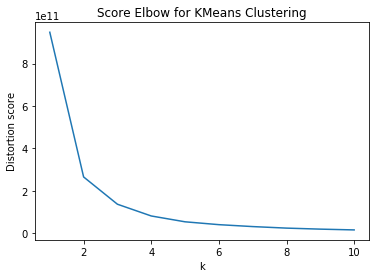

In [32]:
km_eval = []

for i in range(1,11):
    kmeans_model=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans_model.fit(ifood_df_clustering)
    km_eval.append(kmeans_model.inertia_)

# Plot Kmeans for k from 1 to 10 criterion
plt.plot(range(1,11), km_eval)
plt.title('Score Elbow for KMeans Clustering')
plt.xlabel('k')
plt.ylabel('Distortion score')
plt.show()

## Fitting kmeans to the dataset with k=3

In [33]:
## fit and predict clusters
kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
ifood_df_clustering['cluster'] = km4.fit_predict(X)

In [34]:
ifood_df_clustering.cluster.value_counts()

1    761
0    730
2    714
Name: cluster, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56379ac190>,
      dtype=object)

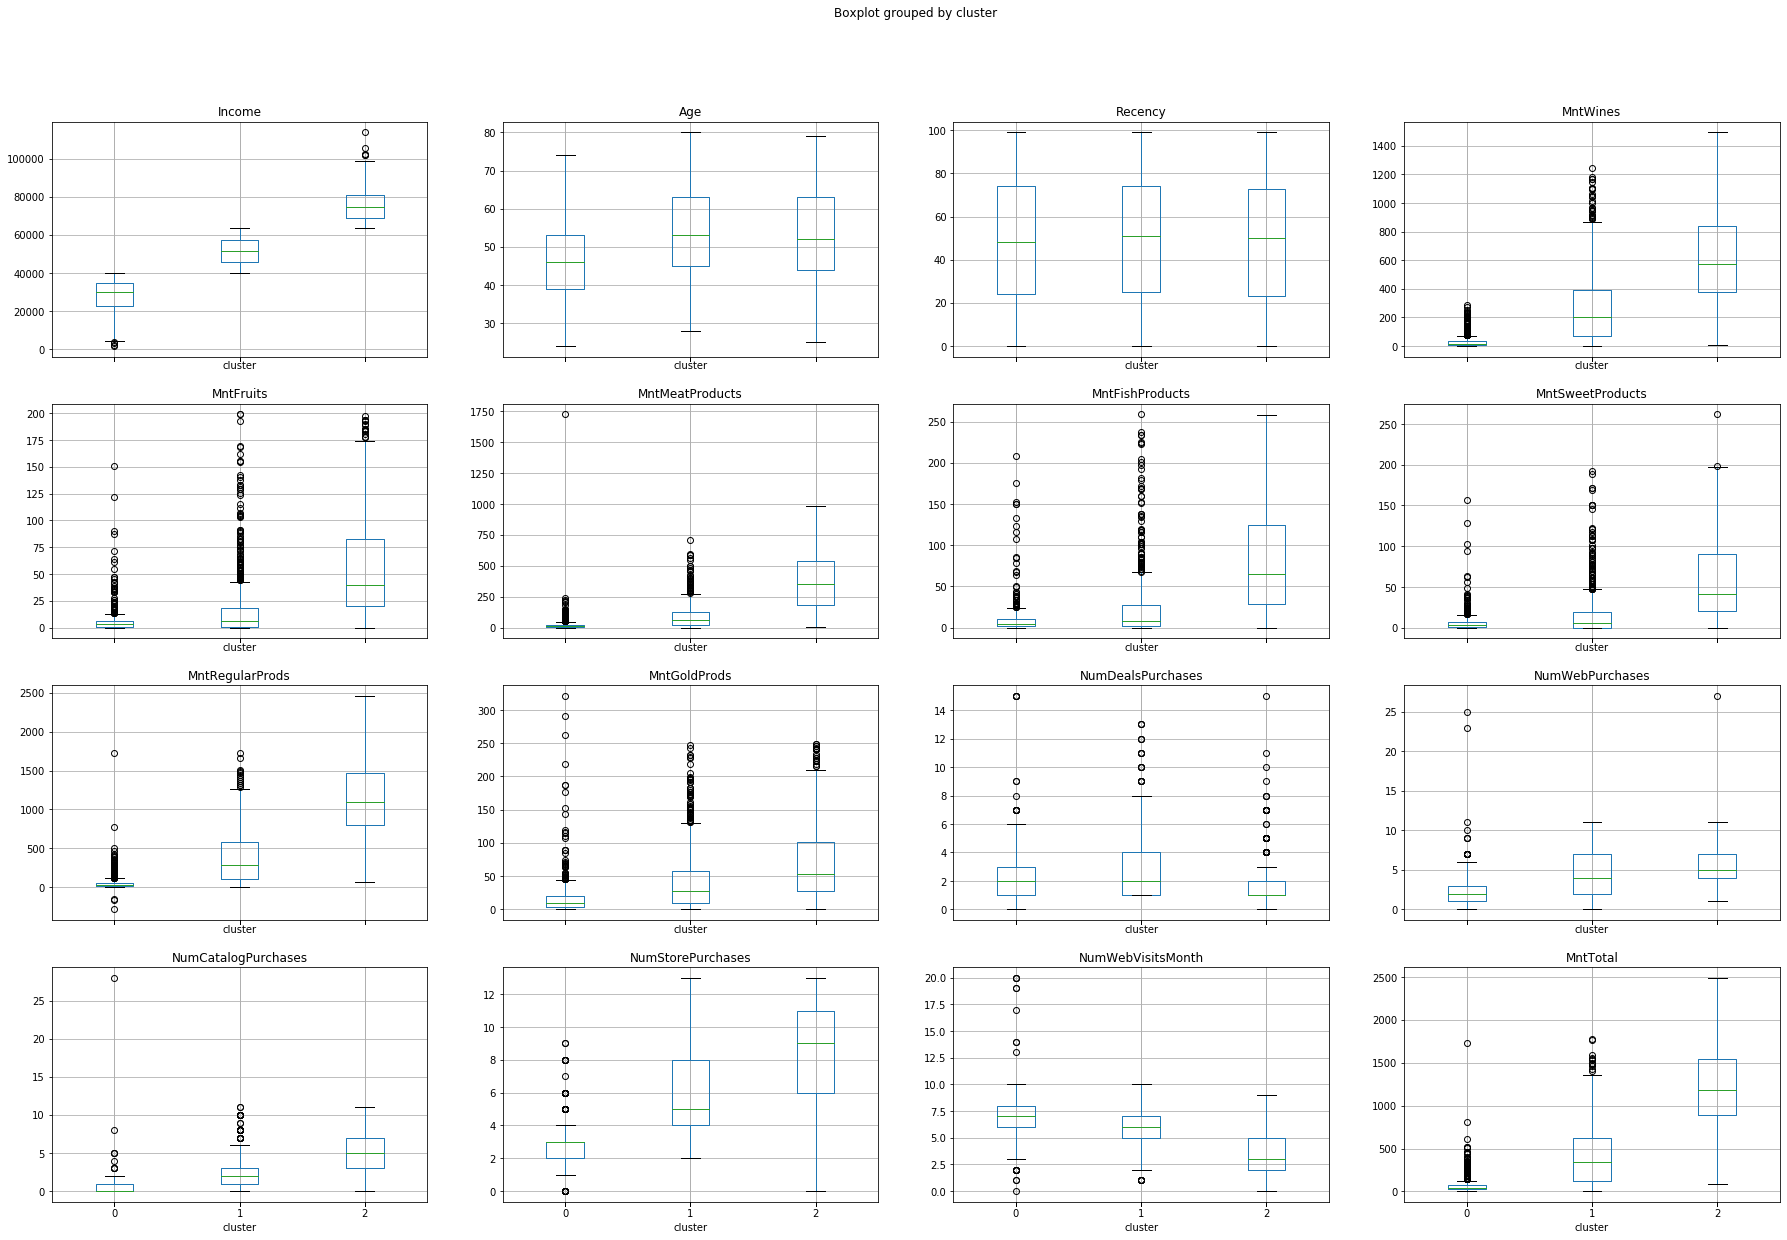

In [84]:
fig, axes = plt.subplots(4,4, sharex= True, sharey= False, figsize=(30,20))

ifood_df_clustering.boxplot(column=['Income', 'Age', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntRegularProds','MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'MntTotal'
       ], ax = axes, by='cluster')


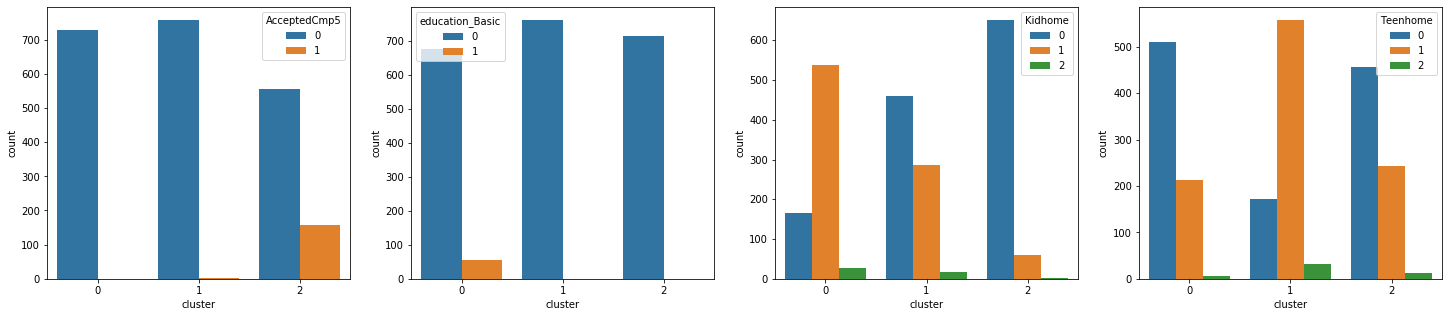

In [95]:
fig, ax = plt.subplots(1,4, figsize=(25,5))

sns.countplot(x="cluster", hue="AcceptedCmp5", data=ifood_df_clustering, ax=ax[0])
sns.countplot(x="cluster", hue="education_Basic", data=ifood_df_clustering, ax=ax[1])
sns.countplot(x="cluster", hue="Kidhome", data=ifood_df_clustering, ax=ax[2])
sns.countplot(x="cluster", hue="Teenhome", data=ifood_df_clustering, ax=ax[3])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74ce680510>,
      dtype=object)

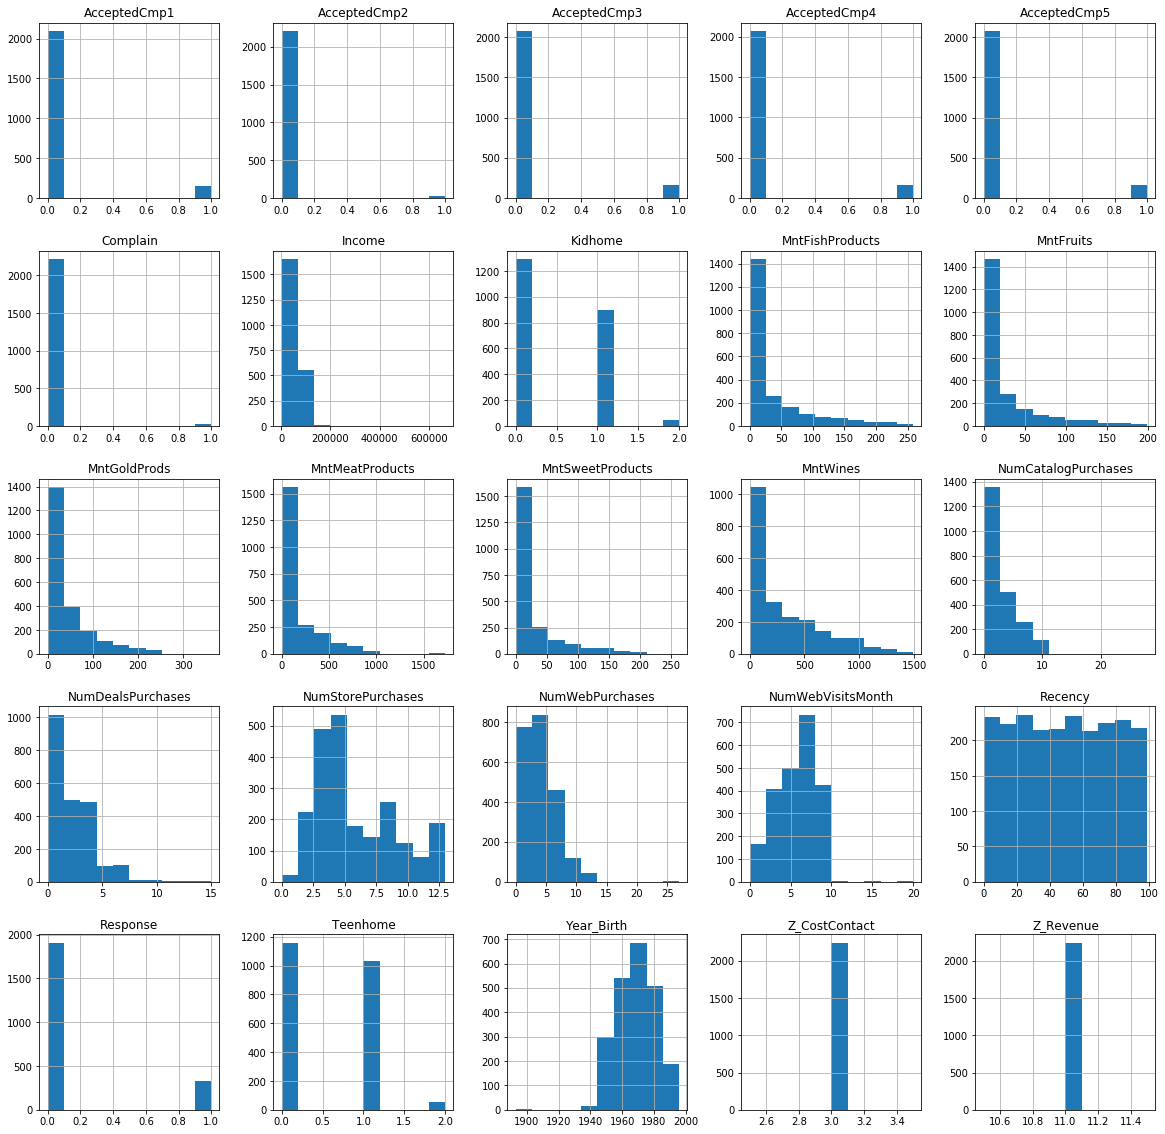

In [17]:
df.drop(['ID'], axis=1).hist(figsize=(20,20))

In [96]:
ifood_df.to_csv('ifood_df.csv', index=False)

---
## Notes:

They sell products from 5 major categories: 
* wines
* rare meat products
* exotic fruits
* specially prepared fish
* sweet products

These can further be divided into: 
* gold
* regular products

3 sales channels: 
* physical stores
* catalogs
* website.
### Data dictionary
![alt text](dictionary.png "Title")